## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mick/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

/Users/mick/anaconda/envs/ee227-py3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#This loads the file that you want, might take several seconds (up to a minute)
with open("data/news_sentiment_nn.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[19])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{b'sentiment_nn': 0.29720652,
                    'person': 'Staffan de Mistura',
                    'text': 'The envoy',
                    'wdid': 'Q1984290'},
                   {b'sentiment_nn': 0.5921626,
                    'person': 'Sergey Lavrov',
                    'text': 'Russian Foreign Minister',
                    'wdid': 'Q58217'},
                   {b'sentiment_nn': 0.38915098,
                    'person': 'John Kerry',
                    'text': 'U.S. Secretary of State',
                    'wdid': 'Q22316'},
                   {b'sentiment_nn': -0.5545976,
                    'person': 'John Kerry',
                    'text': 'in Geneva',
                    'wdid': 'Q22316'},
                   {b'sentiment_nn': 0.6954129,
                    b'wdid': b'233',
                    'person': 'Mohammad Hazzouri',
                    'text': "the head of the city 's Healt

In [3]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [4]:
# get only articles from one story, you can change this
stories = ["ISIS", "BREXIT"]

chosen_story = stories[1]
if chosen_story == "ISIS":
    articles = ISIS_articles
elif chosen_story == "BREXIT":
    articles = Brexit_articles
else:
    raise Exception("No article supported")


## Extract introductions, and obtain their sentiment

In [5]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    sentiments = analyzer.polarity_scores(a['title'])
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        intro['title'] = a['title']
        intro['title_sentiment'] = sentiments['compound']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    sentiments = analyzer.polarity_scores(intro['text'])
    intro['pos_sentiment'] = sentiments['pos']
    intro['neg_sentiment'] = sentiments['neg']
    intro['neu_sentiment'] = sentiments['neu']
    intro['sentiment'] = sentiments['compound']

In [6]:
%load_ext autoreload
%autoreload 2

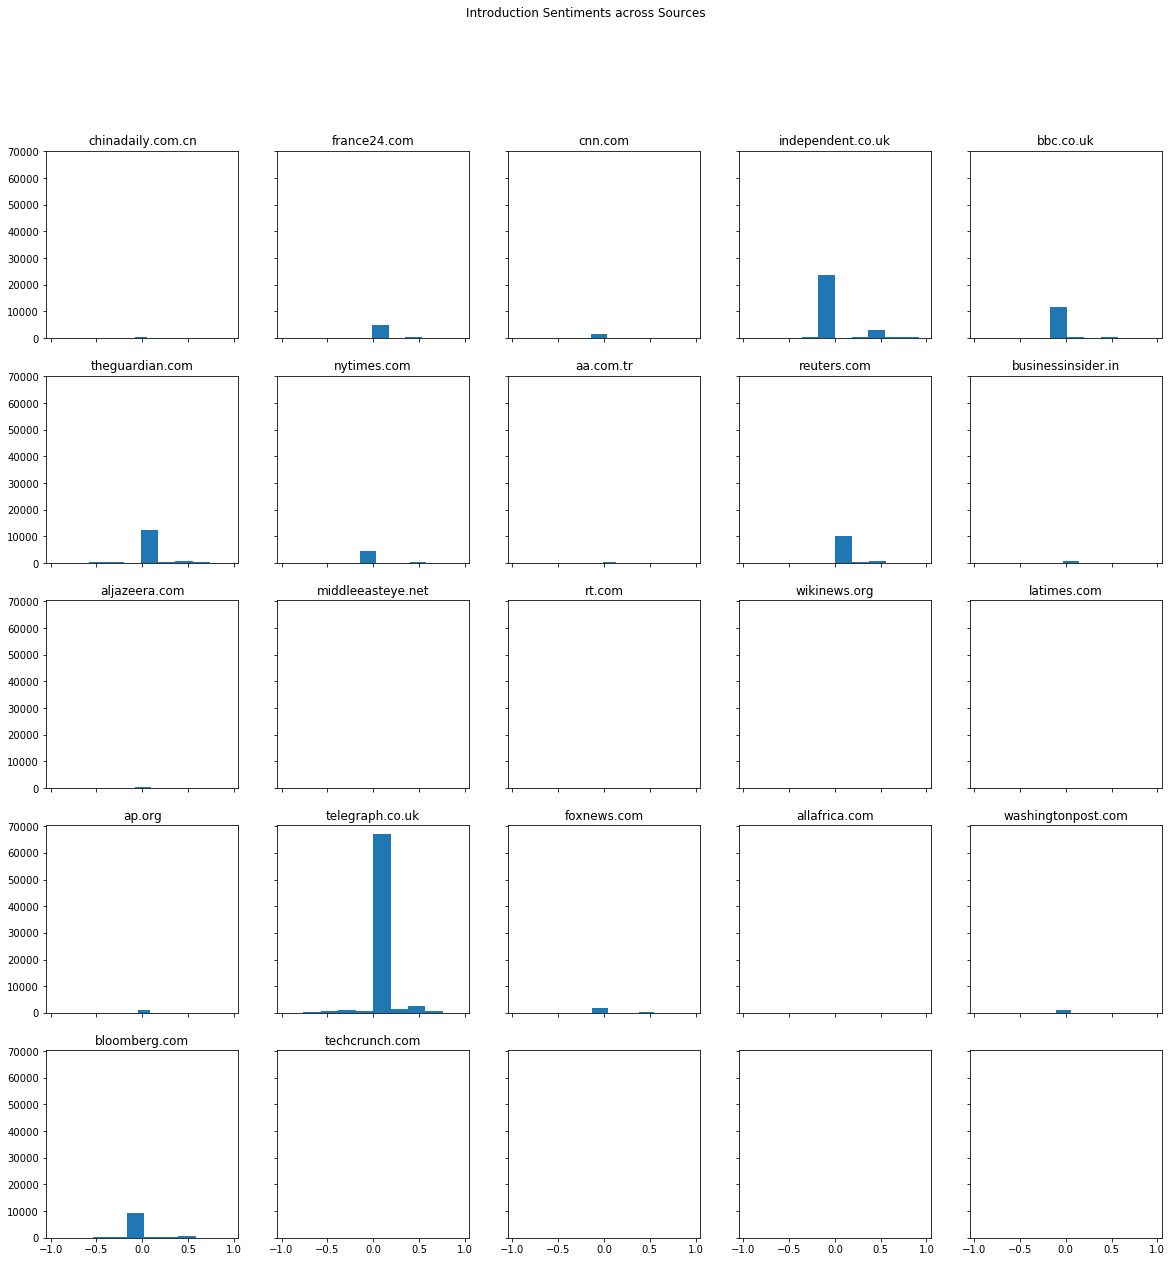

In [7]:
from Visualizer import sentiments_by_sources 
sentiments_by_sources(total_introductions, key='sentiment')

## Augment sentiments

In [8]:
from Featurizer import Featurizer

[nltk_data] Downloading package stopwords to /Users/mick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def add_sentiment_scores(src_file_name, dest_intros, src_key, des_key):
    with open ("data/" + src_file_name, 'rb') as fp:
        liu_intro = pickle.load(fp)
    Featurizer.transfer_val(liu_intro, dest_intros, [src_key], [des_key], 'wdid', 'person')


In [10]:
def examine_feature_weight(weights, feature_names, show=20):
    contribution = [(i,v) for i,v in enumerate(weights)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 *abs(c[1]))
    for i in range(show):
        c = ranked_contrib[i]
        print(np.around(c[1], decimals=3), feature_names[c[0]])
        

In [11]:
if chosen_story == "ISIS":
    add_sentiment_scores('introductions_liu_isis', total_introductions, 'sentiment', 'liu_sentiment')  
elif chosen_story == "BREXIT":
    add_sentiment_scores('introductions_liu_brexit', total_introductions, 'sentiment', 'liu_sentiment')  
else:
    raise Exception("Not supported..")

In [12]:
from Preprocessing import OneHotFeature
one_hot_feats = OneHotFeature(total_introductions, Featurizer())

Text one hot: (172547, 2617)
Title one hot: (172547, 2617)
Source one hot: (172547, 22)
Person one hot: (172547, 10445)


In [13]:
from Preprocessing import SentimentTarget
sentiment_target = SentimentTarget(total_introductions, ['sentiment', 'liu_sentiment', 'title_sentiment', b'sentiment_nn'])

Sentiments: (172547, 4)


## CCA

In [14]:
from Featurizer import random_indx_same_proportions

In [15]:
def print_shapes(*arg):
    for a in arg:
        if type(a) is not list:
            print(a.shape)
        else:
            print(len(a))

In [16]:
X, X_feats = one_hot_feats.get_combined(['text', 'source'])

In [17]:
Y_keys = [b'sentiment_nn', 'sentiment', 'title_sentiment', 'liu_sentiment']
Y_target, Y_feats = sentiment_target.get_poly(Y_keys)

In [18]:
Y_feats

['',
 "b'sentiment_nn'",
 'sentiment',
 'title_sentiment',
 'liu_sentiment',
 "b'sentiment_nn'^2",
 "b'sentiment_nn'sentiment",
 "b'sentiment_nn'title_sentiment",
 "b'sentiment_nn'liu_sentiment",
 'sentiment^2',
 'sentimenttitle_sentiment',
 'sentimentliu_sentiment',
 'title_sentiment^2',
 'title_sentimentliu_sentiment',
 'liu_sentiment^2']

In [19]:
print_shapes(X, Y_target, X_feats)
assert X.shape[0] == Y_target.shape[0]

(172547, 2639)
(172547, 15)
2639


In [20]:
small_idx = random_indx_same_proportions(total_introductions, 20000)
small_X_cca = X[small_idx]
small_Y_cca = Y_target[small_idx]

In [21]:
print_shapes(small_X_cca, small_Y_cca)

(19998, 2639)
(19998, 15)


In [22]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
cca.fit(small_X_cca, small_Y_cca)

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [23]:
print("Most positive weights")
pos_weights = np.copy(cca.x_weights_[:,0])
pos_weights[pos_weights < 0] = 0
examine_feature_weight(pos_weights, X_feats, show=20) 
print("Most negative weights")

neg_weights = np.copy(cca.x_weights_[:,0])
neg_weights[neg_weights > 0] = 0
examine_feature_weight(neg_weights, X_feats, show=20) 

Most positive weights
0.669 txt:parti
0.233 txt:justic
0.173 txt:champion
0.155 txt:rescu
0.138 txt:suprem
0.121 txt:friend
0.106 txt:conserv
0.105 txt:support
0.098 txt:respect
0.095 txt:best
0.091 txt:hope
0.084 txt:unit
0.083 txt:great
0.082 txt:opposit
0.079 txt:treasuri
0.077 txt:succeed
0.071 txt:agreement
0.069 txt:special
0.069 txt:hand
0.068 txt:secur
Most negative weights
-0.084 txt:anti
-0.073 txt:fail
-0.063 txt:strike
-0.059 txt:slip
-0.058 txt:memori
-0.05 txt:admit
-0.044 txt:wo
-0.042 txt:principl
-0.041 txt:lead
-0.04 txt:hust
-0.04 txt:broke
-0.039 txt:resign
-0.038 txt:ride
-0.037 txt:despit
-0.037 txt:concern
-0.036 txt:alleg
-0.035 txt:jo
-0.034 txt:argu
-0.034 txt:weapon
-0.034 txt:right


In [24]:
examine_feature_weight(cca.y_weights_[:,0], Y_feats, show=len(Y_feats)) 

0.801 sentiment
0.542 sentiment^2
-0.205 liu_sentiment
-0.146 sentimentliu_sentiment
-0.021 b'sentiment_nn'
-0.018 b'sentiment_nn'liu_sentiment
-0.011 b'sentiment_nn'title_sentiment
-0.01 liu_sentiment^2
0.009 title_sentiment
-0.006 sentimenttitle_sentiment
-0.004 title_sentiment^2
0.002 b'sentiment_nn'^2
-0.002 b'sentiment_nn'sentiment
0.0 title_sentimentliu_sentiment
0.0 


In [25]:
Y_combined = np.matmul(Y_target, cca.y_weights_)

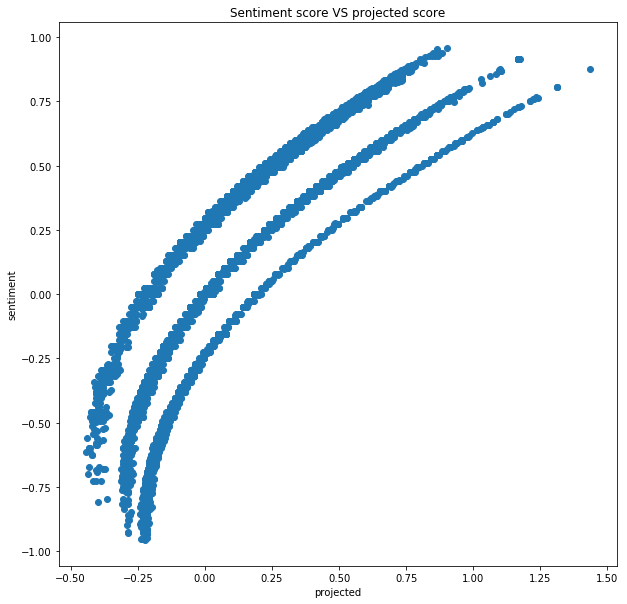

In [26]:
import matplotlib.pyplot as plt
plt.scatter(Y_combined[:], Y_target[:,2])
plt.title("Sentiment score VS projected score")
plt.xlabel("projected")
plt.ylabel("sentiment")
plt.show()

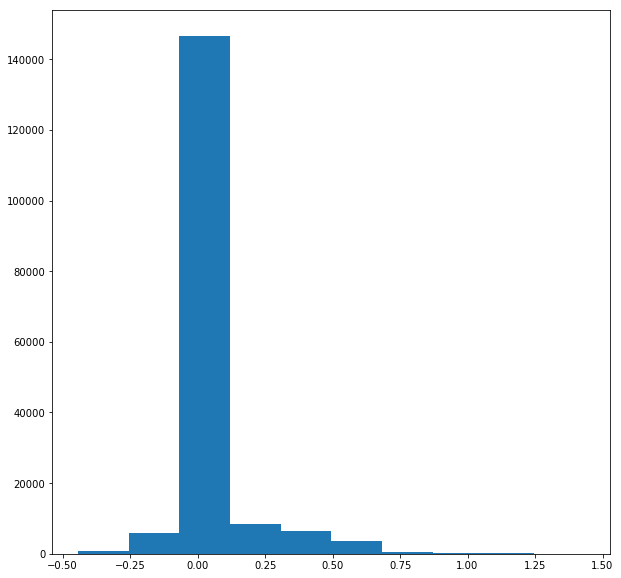

In [27]:
plt.hist(Y_combined)
plt.show()

In [28]:
for i in range(len(total_introductions)):
    total_introductions[i]['processed_sentiment'] = -1 * Y_combined[i][0]

In [29]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 5)
for intro in subsample:
    if intro['processed_sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])
        print("Processed sentiment:", intro['processed_sentiment'])


---------------
Entity mentionned: Daniel Finkelsteinin
the Times ( paywall )
Sentiment: 0.0
Processed sentiment: 0.008406383443087612
---------------
Entity mentionned: Farage
Mr
Sentiment: 0.0
Processed sentiment: 0.005424463072322208
---------------
Entity mentionned: George Freeman
ory MP
Sentiment: 0.0
Processed sentiment: 0.0012077600532983776
---------------
Entity mentionned: Bush
Mr
Sentiment: 0.0
Processed sentiment: 0.0118226862657556
---------------
Entity mentionned: Christopher Hope

Sentiment: 0.0
Processed sentiment: 0.009380829949296812


## Build a 2-dimensional object containing sentiment per entity, per source

In [30]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['processed_sentiment'])


In [31]:
# An example of how one entity (a city) is described by different sources
# print(ent_source_sent['Aleppo'])

In [32]:
# We get rid of entities that don't contain enough data

entities_kept = []
for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 4525  /  13497 in our dataset
We have  22 sources:  ['businessinsider.in', 'aa.com.tr', 'allafrica.com', 'wikinews.org', 'nytimes.com', 'reuters.com', 'techcrunch.com', 'cnn.com', 'france24.com', 'theguardian.com', 'foxnews.com', 'washingtonpost.com', 'independent.co.uk', 'rt.com', 'aljazeera.com', 'ap.org', 'bloomberg.com', 'chinadaily.com.cn', 'middleeasteye.net', 'bbc.co.uk', 'telegraph.co.uk', 'latimes.com']


## We create the array we will use in our sparse model

In [33]:
all_sents = []
for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        all_sents.append(np.array(ent_source_sent[entity][source]))

std_val = np.std(np.concatenate(all_sents))
mean_val = np.mean(np.concatenate(all_sents))

def z_score(sent_val):
    return (sent_val - mean_val) / std_val  

In [34]:
Pos_neg_ratio = 2.0
overall_ratio = 0.15
z_score_thresh = 0.7

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        
        z_scores = np.array([z_score(s) for s in sent_array])
        N_pos = np.sum(z_scores > z_score_thresh)
        N_neg = np.sum(z_scores < -1 * z_score_thresh)   
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 9425, -1: 2712, 1: 960})


In [35]:
def remove_zero_column(mat, sources):
    assert mat.shape[1] == len(sources)
    zero_column = np.sum(np.abs(A), axis=0) == 0
    non_zero = np.logical_not(zero_column)
    selected = np.array(sources)[zero_column]
    print("Removing the following sources ", list(selected))
    return mat[:, non_zero], list(np.array(sources)[non_zero])


## Model source similarity

In [36]:
A_full_ranked, final_sources =  remove_zero_column(A, sources)

Removing the following sources  ['wikinews.org', 'techcrunch.com']


In [37]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A_full_ranked)


In [38]:
def get_sorted_index(data):
    contribution = [(i,v) for i,v in enumerate(data)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 * (c[1]))
    return [i for (i,v) in ranked_contrib]

def plot_stats_along_sources(A_stats, sources, title):
    assert len(A_stats) == len(sources)
    n = len(sources)
    sorted_idx = get_sorted_index(A_stats)
    plt.bar(np.arange(n), A_stats[sorted_idx])
    plt.xticks(np.arange(n), np.array(sources)[sorted_idx], rotation='vertical')
    plt.title(title)
    plt.show()
    

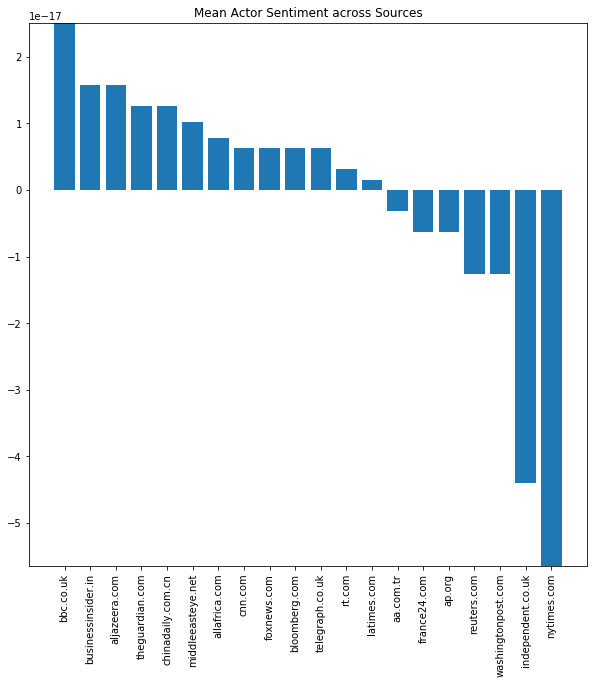

In [39]:
plot_stats_along_sources(np.mean(A_std, axis=0), final_sources, "Mean Actor Sentiment across Sources")

In [40]:
from sklearn.covariance import GraphLasso
graph_lasso = GraphLasso(alpha=0.01)
graph_lasso.fit(A_std)
np.mean(graph_lasso.get_precision() > 0)

for (i, j) in zip(*np.where(abs(graph_lasso.get_precision()) > 0)):
    if i > j:
        print(final_sources[i], final_sources[j])

aa.com.tr businessinsider.in
allafrica.com aa.com.tr
nytimes.com businessinsider.in
nytimes.com aa.com.tr
reuters.com businessinsider.in
reuters.com allafrica.com
reuters.com nytimes.com
cnn.com businessinsider.in
cnn.com aa.com.tr
cnn.com allafrica.com
cnn.com nytimes.com
cnn.com reuters.com
france24.com businessinsider.in
france24.com aa.com.tr
france24.com allafrica.com
france24.com nytimes.com
france24.com reuters.com
france24.com cnn.com
theguardian.com businessinsider.in
theguardian.com aa.com.tr
theguardian.com allafrica.com
theguardian.com nytimes.com
theguardian.com reuters.com
theguardian.com cnn.com
theguardian.com france24.com
foxnews.com businessinsider.in
foxnews.com aa.com.tr
foxnews.com allafrica.com
foxnews.com nytimes.com
foxnews.com reuters.com
foxnews.com cnn.com
foxnews.com france24.com
foxnews.com theguardian.com
washingtonpost.com businessinsider.in
washingtonpost.com aa.com.tr
washingtonpost.com nytimes.com
washingtonpost.com reuters.com
washingtonpost.com cnn.c

## Workspace

In [ ]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [44]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

0.1


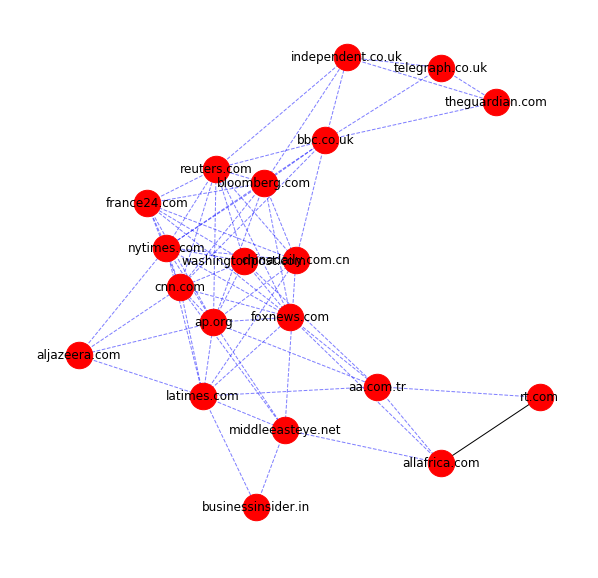

0.11


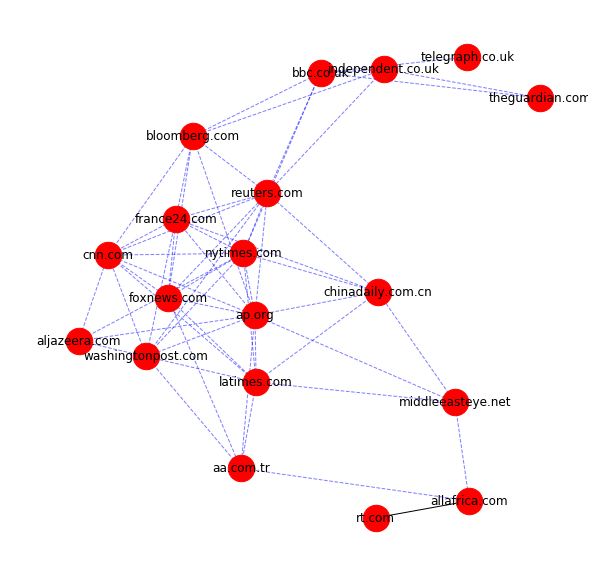

0.12


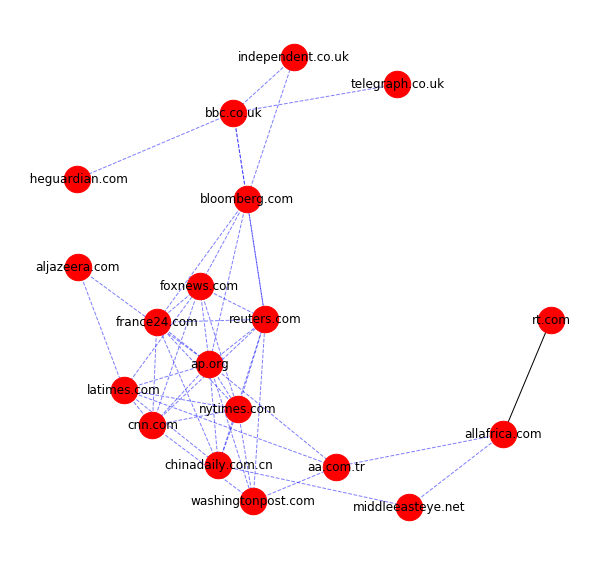

0.13


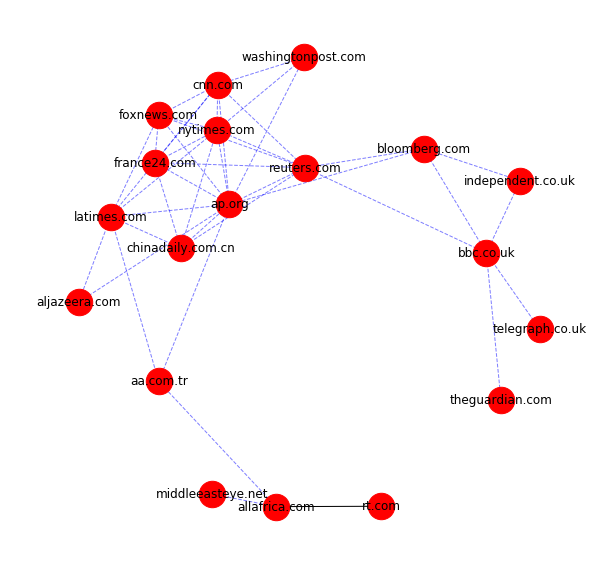

0.13999999999999999


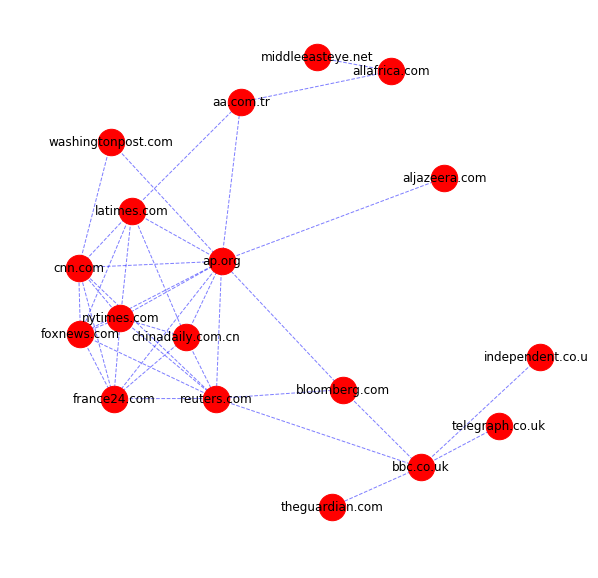

0.14999999999999997


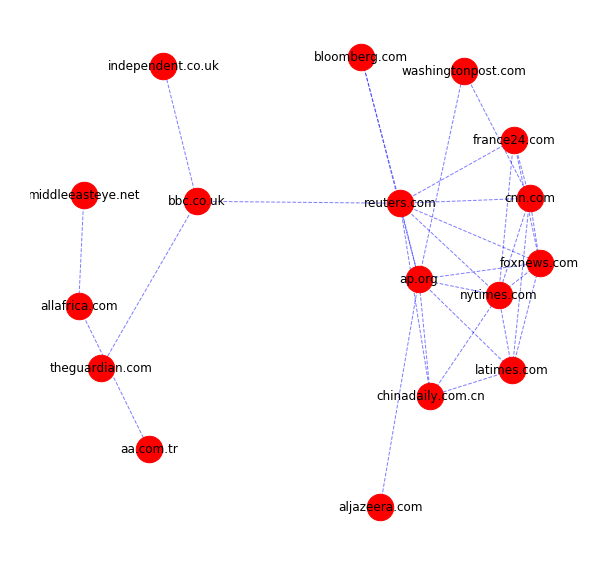

0.15999999999999998


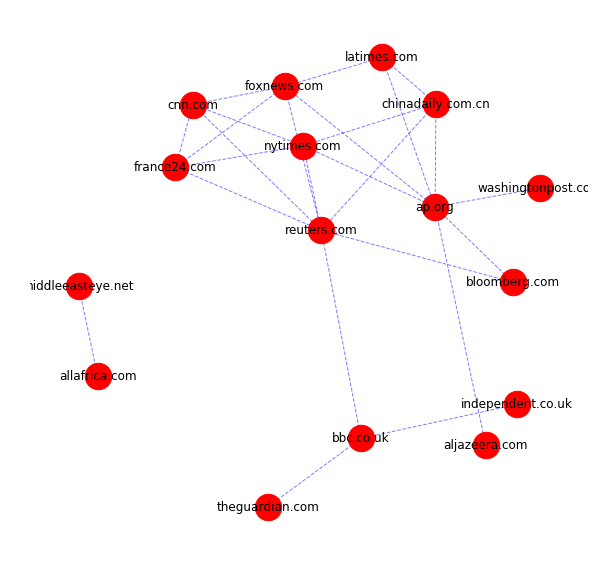

0.16999999999999998


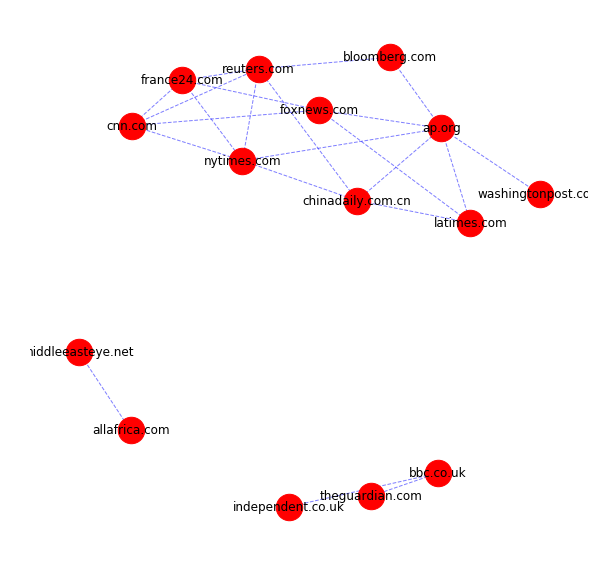

0.17999999999999997


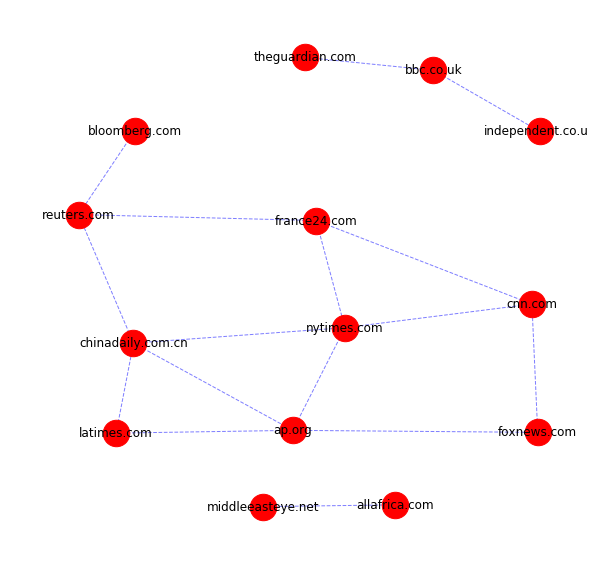

0.18999999999999995


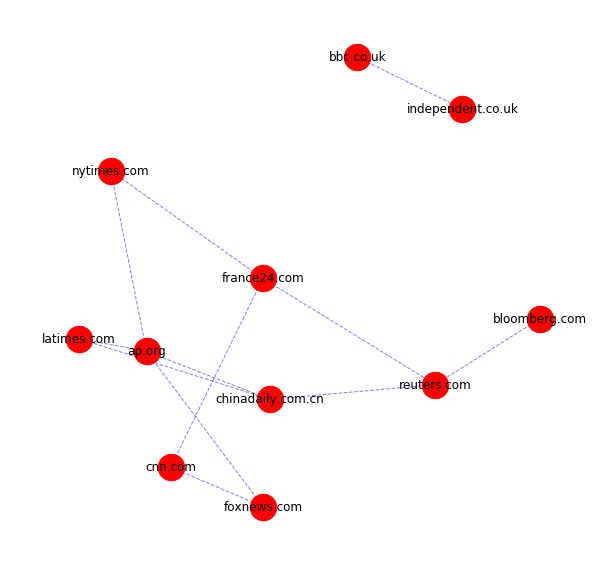

In [45]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    graph_lasso = GraphLasso(alpha=l1_lambda)
    graph_lasso.fit(A_std)
    plot_network(graph_lasso.get_precision(), final_sources)

In [ ]:
from GraphicalLasso import GraphicalLasso as GL
from GramLassoSolver import GramLassoSolver as GramLasso
from sklearn import linear_model
def my_graphical_lasso(data, l1_lambda):
    gl = GL(l1_solver_f=GramLasso)
    S = np.cov(data.T)
    return gl.fit(S, l1_lambda)

## Our Glasso: Lambda sweeping

In [ ]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    plot_network(my_graphical_lasso(A_std, l1_lambda), final_sources)

## Neighborhood method

In [41]:
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso
from Lasso import Lasso2

In [42]:
n_sel = NGraphSelection(Lasso2)
g = n_sel.fit(A_std, 0.10, 'AND')

0.1


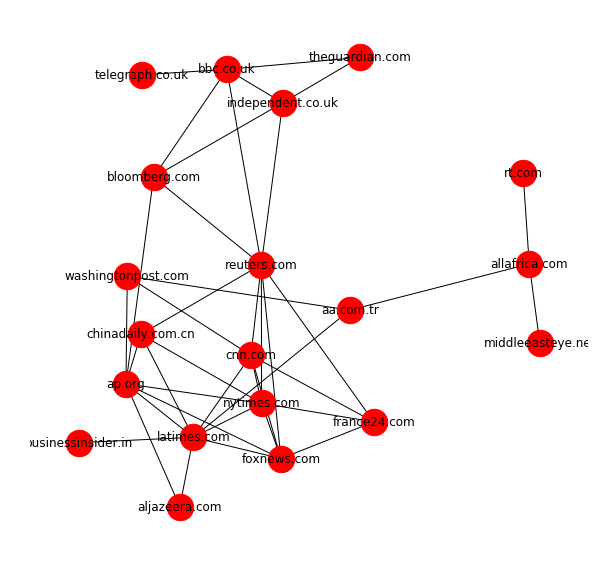

0.11


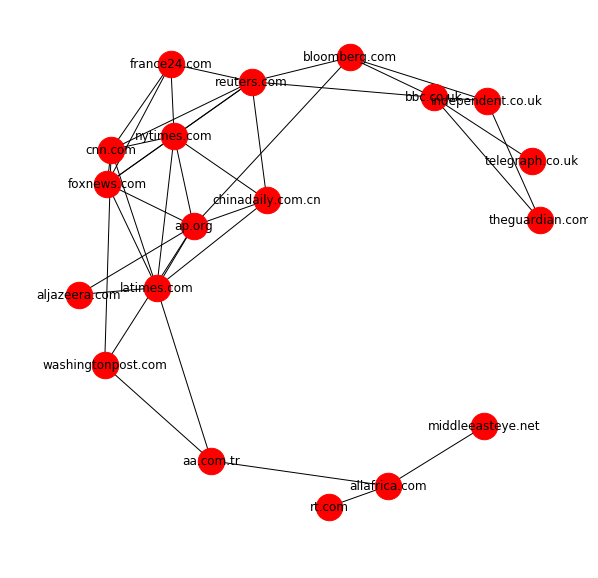

0.12


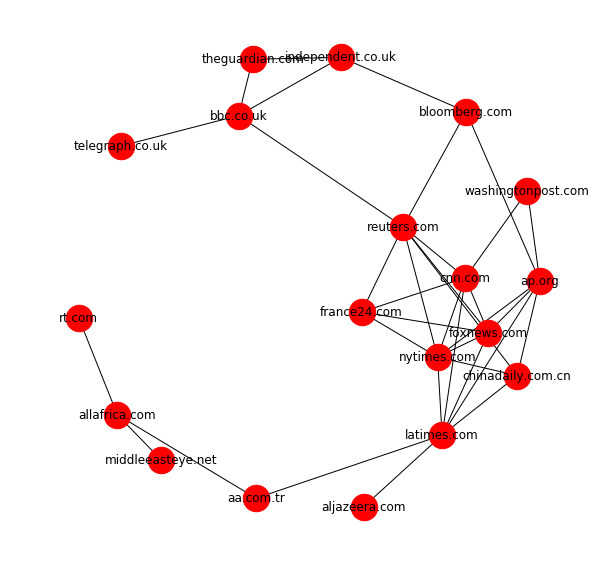

0.13


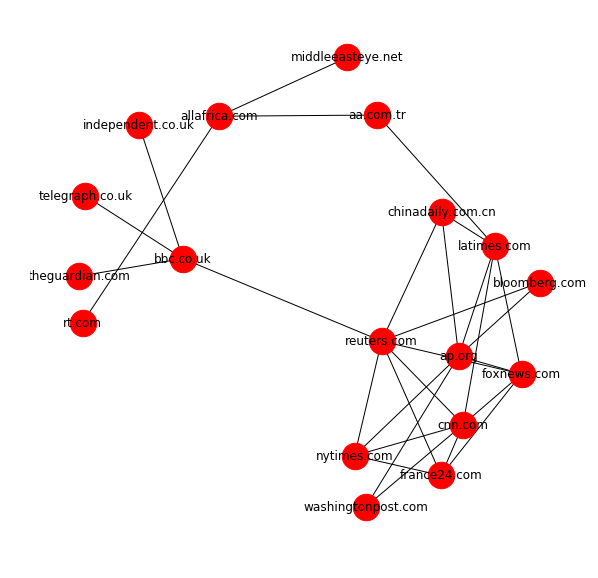

0.13999999999999999


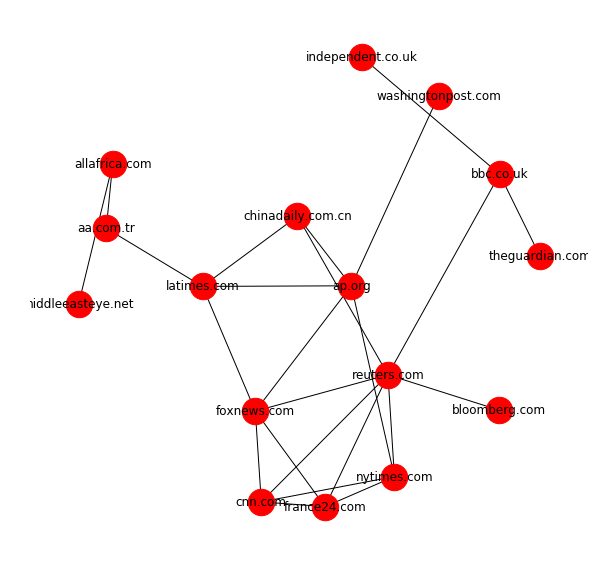

0.14999999999999997


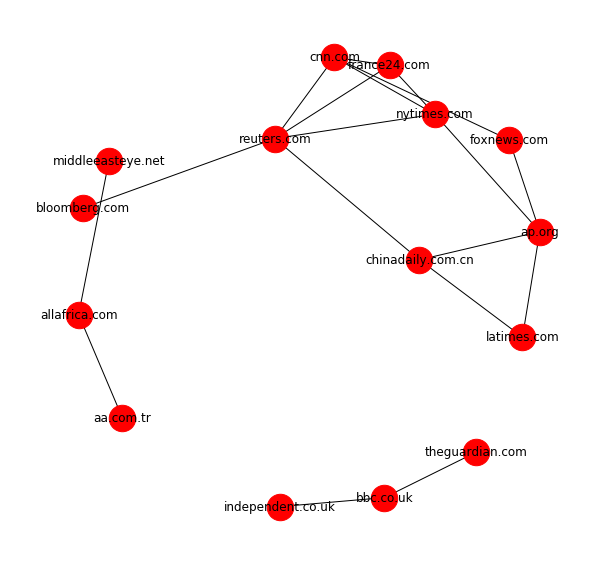

0.15999999999999998


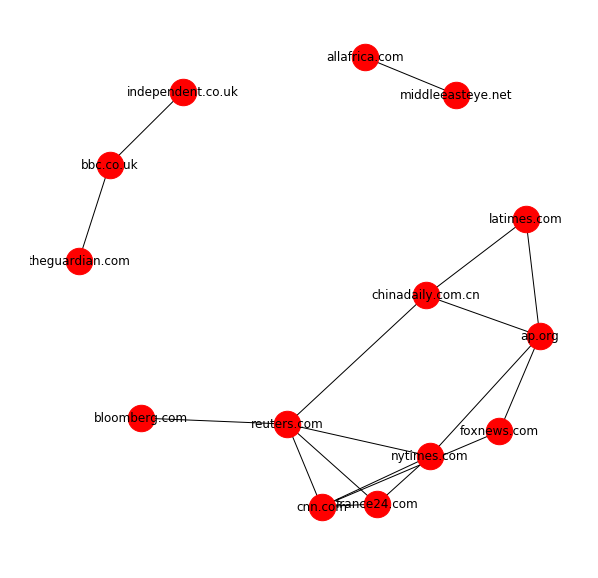

0.16999999999999998


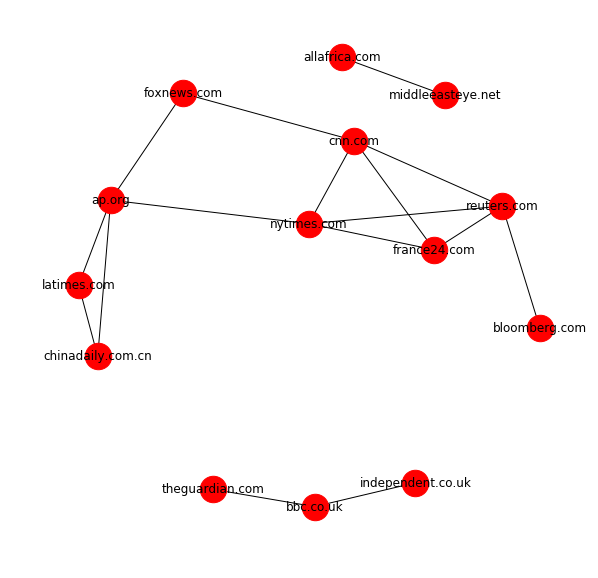

0.17999999999999997


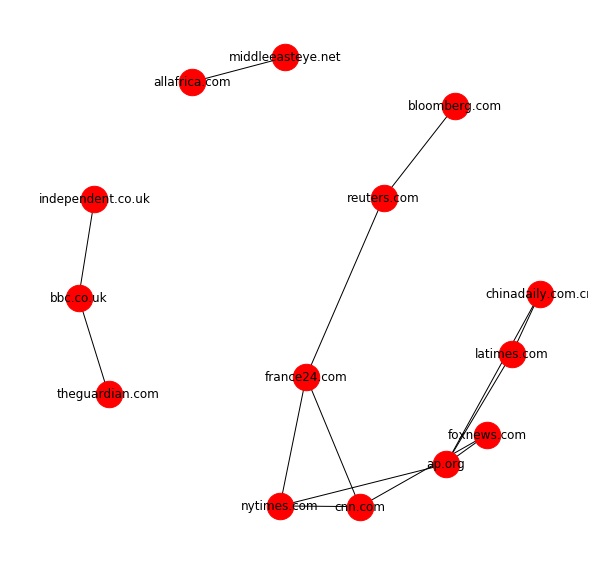

0.18999999999999995


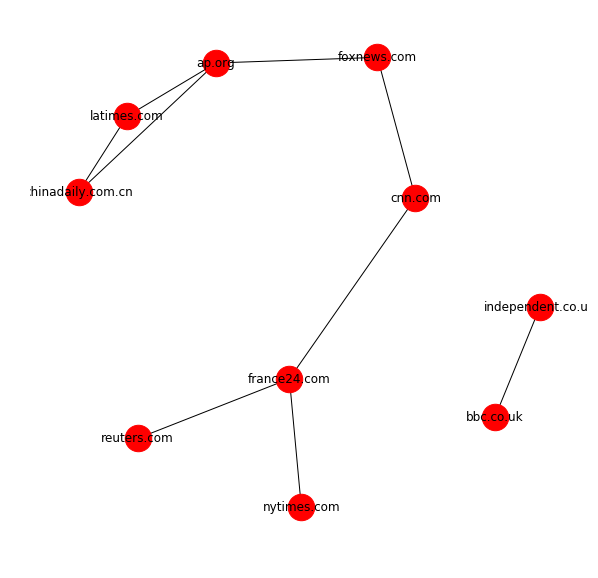

In [46]:
for i in np.arange(0.10,0.20, 0.01):
    l1_lambda = i
    print(l1_lambda)
    plot_network(n_sel.fit(A_std, l1_lambda, 'AND'), final_sources)

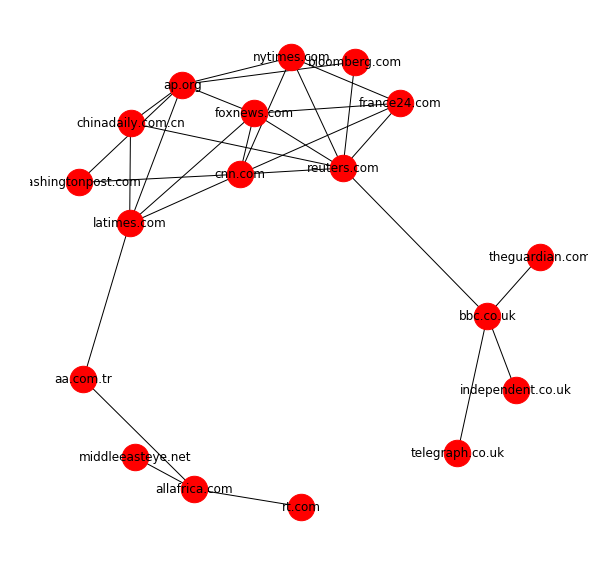

In [51]:
# BREIXT 0.125
# ISIS 0.13
best_lambda = 0.13
save_file = None
# save_file = "results/fig/" + chosen_story + str(best_lambda).split(".")[1]
plot_network(n_sel.fit(A_std, best_lambda, 'AND'), final_sources, save_file)

In [52]:
from datetime import datetime
experiment_name = chosen_story + "-CCA"
params = {
    "pos_neg_ratio": Pos_neg_ratio,
    "overall_ratio": overall_ratio,
    "z_score_thresh": z_score_thresh,
    "lambda": best_lambda,
    "Y_feats": Y_feats,
    "X_feats": X_feats,
}
result = {
    "processing": ["augment_y", "equal sampling", "CCA", "z-score"],
    "A": A,
    "A_std": A_std,
    "sources": final_sources
}
experiment = {
    "params" : params,
    "result": result
}
file_name = "results/" + experiment_name + "_" + datetime.now().strftime('%m%d%H%M%S')
print("Saving " + file_name + "...")
np.save(file_name, experiment)
save = True

Saving results/BREXIT-CCA_0506184222...
